# Data engineering

## Load data

Loads images and masks. Shows overlay.

In [59]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [60]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
batch_size = 16
image_size = (128, 128)
validation_size = int(1e3)
img_folder = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/"
mask_folder = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/"


In [62]:
def work_with_image(file_path):
    img_data = tf.io.read_file(file_path)
    img_tensor = tf.image.decode_jpeg(img_data, channels=3)
    img_tensor = tf.image.convert_image_dtype(img_tensor, dtype=tf.float32)
    img_tensor = tf.image.resize(img_tensor, image_size)
    return tf.clip_by_value(img_tensor, 0.0, 1.0)

def work_with_mask(file_path):
    mask = work_with_image(file_path)[:, :, 0]
    mask = tf.clip_by_value(mask, 0.0, 1.0) 
    return mask

def display_image(image, title=None, transparency=1, cmap=None):
    image = image.numpy().squeeze() 
    plt.imshow(image, alpha=transparency, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis("off")

def display_series(dataset, rows=3, cols=3, figure_size=(10, 15)):
    sample_images, sample_masks = next(iter(dataset.take(1)))

    plt.figure(figsize=figure_size)
    for index in range(1, rows * cols + 1, cols):
        plt.subplot(rows, cols, index)
        display_image(sample_images[index], title="Original Image")

        plt.subplot(rows, cols, index + 1)
        display_image(sample_masks[index], title="Original Mask", cmap='gray')

        plt.subplot(rows, cols, index + 2)
        plt.title('Image and Mask Overlay')
        plt.imshow(sample_masks[index], alpha=0.8, cmap='binary_r')
        plt.imshow(sample_images[index], alpha=0.5)
        plt.axis('off')

    plt.show()


In [63]:
metadata = pd.read_csv("/kaggle/input/augmented-forest-segmentation/meta_data.csv")

metadata['image'] = metadata['image'].map(lambda name: os.path.join(img_folder, name))
metadata['mask'] = metadata['mask'].map(lambda name: os.path.join(mask_folder, name))


In [64]:
image_dataset = tf.data.Dataset.from_tensor_slices(metadata['image'])
mask_dataset = tf.data.Dataset.from_tensor_slices(metadata['mask'])

image_dataset = image_dataset.map(work_with_image)
mask_dataset = mask_dataset.map(work_with_mask)

paired_dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))
paired_dataset = paired_dataset.shuffle(buffer_size=1000).repeat(2).batch(batch_size)


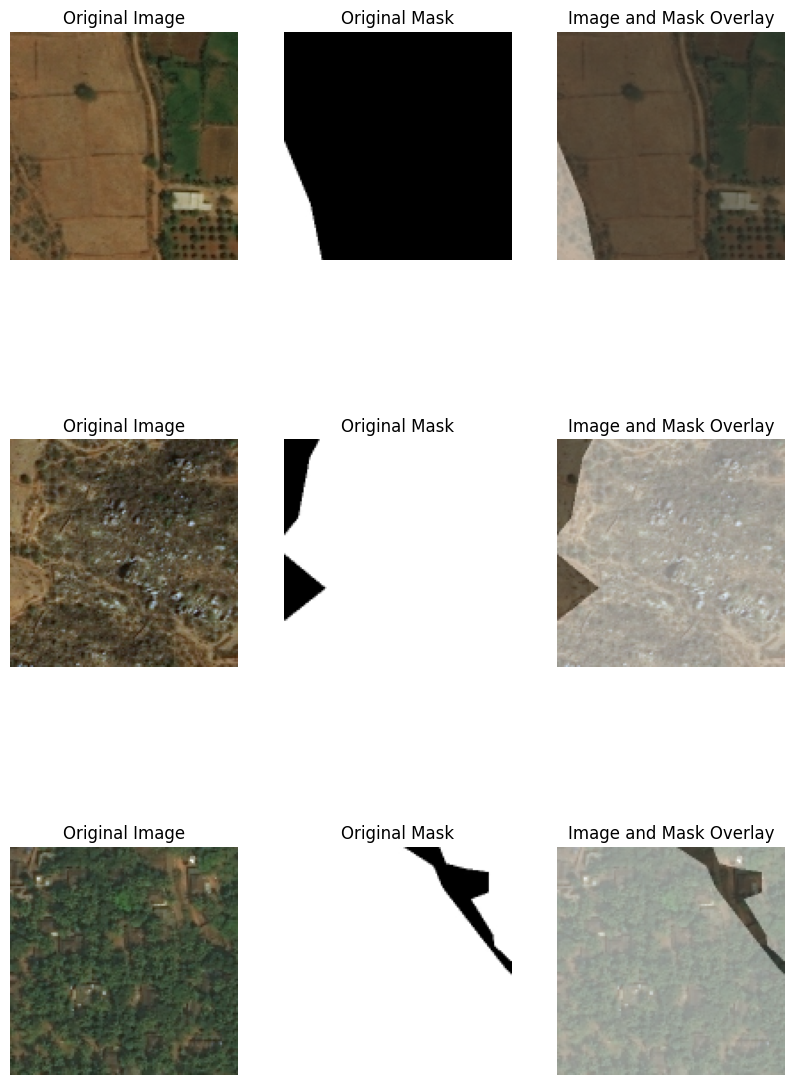

In [65]:
display_series(paired_dataset)

## Augment data

Adds diversity via augmentaitons.

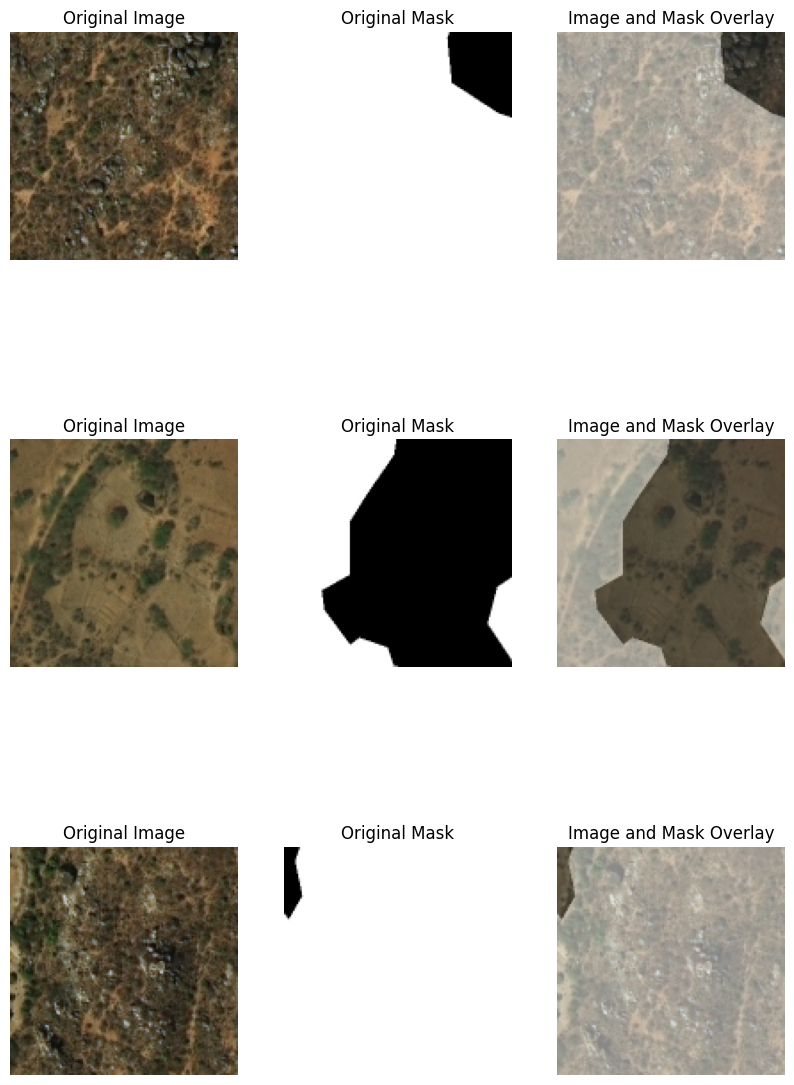

In [66]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

def augment_image_and_mask(image, mask):
    mask = tf.expand_dims(mask, axis=-1)
    combined = tf.concat([image, mask], axis=-1)

    num_rotations = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
    combined = tf.image.rot90(combined, k=num_rotations)

    if tf.random.uniform([]) > 0.5:
        combined = tf.image.flip_left_right(combined)

    augmented_image = combined[..., :-1]
    augmented_mask = combined[..., -1]

    return augmented_image, augmented_mask

def apply_augmentation(dataset):

    return (
        dataset
        .map(augment_image_and_mask, num_parallel_calls=AUTOTUNE)
        .cache()
        .prefetch(AUTOTUNE)
    )

augmented_ds = apply_augmentation(paired_dataset)
display_series(augmented_ds)


## Perform splits

Forms train, validation and test sets.

In [68]:
import tensorflow.data as tfd

In [ ]:
test_ds = augmented_ds.take(validation_size // batch_size).prefetch(AUTOTUNE) 
valid_ds = augmented_ds.skip(validation_size // batch_size).take(validation_size // batch_size).prefetch(AUTOTUNE)
train_ds = augmented_ds.skip(2 * (validation_size // batch_size)).prefetch(AUTOTUNE) 

train_samples = tfd.experimental.cardinality(train_ds).numpy() * batch_size

# Model engineering


Declare and train 5 models

In [70]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    device_name = '/GPU:0'  
    print(f"Using device: {device_name}")
else:
    device_name = '/CPU:0'  
    print("No GPU found. Using CPU.")
    

Using device: /GPU:0


## Custom U-Net

In [73]:
!pip install -q git+https://github.com/tensorflow/examples.git

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [71]:

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.callbacks import EarlyStopping


In [72]:

base_model = keras.applications.MobileNetV2(
    input_shape=(*image_size, 3),
    include_top=False
)

layer_names = [
    'block_1_expand_relu',  
    'block_3_expand_relu',   
    'block_6_expand_relu',  
    'block_13_expand_relu',  
    'block_16_project',    
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

encoder = keras.Model(
    inputs=base_model.input,
    outputs=base_model_outputs,
    name="Encoder"
)

encoder.trainable = False

In [75]:
decoder = [
    pix2pix.upsample(512, 3), 
    pix2pix.upsample(256, 3),  
    pix2pix.upsample(128, 3),  
    pix2pix.upsample(64, 3),   
]

In [76]:
def CustomUNet(encoder_block, decoder_block, output_channels=1, **kwargs):

    inputs = keras.Input(shape=(*image_size, 3), name="ImageInput")

    encodings = encoder_block(inputs)
    skips = reversed(encodings[:-1])        
    encoding = encodings[-1]

    for index, (up, skip) in enumerate(zip(decoder_block, skips)):
        encoding = up(encoding)
        encoding = layers.Concatenate(name=f"ConCat-{index+1}")([encoding, skip])

    mask_out = layers.Conv2DTranspose(
        filters=1,
        kernel_size=3,
        strides=2,
        padding="same",
    )(encoding)
    
    mask_out = layers.Conv2D(
        filters=1,
        kernel_size=1,
        padding="same",
        activation='sigmoid',
        name="MaskOut"
    )(mask_out)

    model = keras.Model(inputs, mask_out, **kwargs)
    
    return model

In [79]:
UNet_model = CustomUNet(encoder, decoder, name="CustomUNet")
UNet_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

steps_per_epoch = train_samples//32

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

with tf.device(device_name):
    history = UNet_model.fit(
        train_ds,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_ds,
        epochs=50,
        callbacks=[early_stopping]
    )


Epoch 1/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.7125 - loss: 0.5396 - val_accuracy: 0.7780 - val_loss: 0.5025
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7750 - loss: 0.4709 - val_accuracy: 0.7856 - val_loss: 0.4526
Epoch 3/50
  1/257 ━━━━━━━━━━━━━━━━━━━━ 15:25 4s/step - accuracy: 0.7954 - loss: 0.4029

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7954 - loss: 0.4029 - val_accuracy: 0.7855 - val_loss: 0.4531
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7769 - loss: 0.4571 - val_accuracy: 0.7866 - val_loss: 0.4580
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7827 - loss: 0.4554 - val_accuracy: 0.7890 - val_loss: 0.4441
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8118 - loss: 0.3796 - val_accuracy: 0.7893 - val_loss: 0.4437
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7823 - loss: 0.4455 - val_accuracy: 0.7892 - val_loss: 0.4495
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7866 - loss: 0.4468 - val_accuracy: 0.7893 - val_loss: 0.4437
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8197 - loss: 0.3702 - val_accuracy: 0.7898 - val_loss: 0.4422
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7859 - loss: 0.4379 - val_accuracy: 0.7921 

## SegNet

In [80]:
import torch
import torch.nn as nn
import numpy as np

In [82]:
import tensorflow as tf
from tensorflow.keras import layers, Model


class DepthwiseSeparableConv(tf.keras.layers.Layer):
    def __init__(self, input_channels, output_channels, kernel_size):
        super().__init__()
        self.depthwise = layers.DepthwiseConv2D(
            kernel_size=kernel_size, padding="same", depth_multiplier=1, use_bias=False
        )
        self.pointwise = layers.Conv2D(output_channels, kernel_size=1, use_bias=False)
        self.bn = layers.BatchNormalization()
        self.activation = layers.ReLU()

    def call(self, inputs, training=False):
        x = self.depthwise(inputs)
        x = self.pointwise(x)
        x = self.bn(x, training=training)
        return self.activation(x)


class DownConv2(tf.keras.layers.Layer):
    def __init__(self, input_channels, output_channels, kernel_size):
        super().__init__()
        self.conv1 = tf.keras.Sequential([
            DepthwiseSeparableConv(input_channels, output_channels, kernel_size),
            layers.Dropout(0.3)  
        ])
        self.conv2 = DepthwiseSeparableConv(output_channels, output_channels, kernel_size)
        self.pool = layers.MaxPooling2D(pool_size=(2, 2), strides=2)  

    def call(self, inputs, training=False):
        x = self.conv1(inputs, training=training)
        x = self.conv2(x, training=training)
        pooled = self.pool(x)
        return pooled, x.shape  


class DownConv3(tf.keras.layers.Layer):
    def __init__(self, input_channels, output_channels, kernel_size):
        super().__init__()
        self.conv1 = tf.keras.Sequential([
            DepthwiseSeparableConv(input_channels, output_channels, kernel_size),
            layers.Dropout(0.3)  
        ])
        self.conv2 = DepthwiseSeparableConv(output_channels, output_channels, kernel_size)
        self.conv3 = DepthwiseSeparableConv(output_channels, output_channels, kernel_size)
        self.pool = layers.MaxPooling2D(pool_size=(2, 2), strides=2)

    def call(self, inputs, training=False):
        x = self.conv1(inputs, training=training)
        x = self.conv2(x, training=training)
        x = self.conv3(x, training=training)
        pooled = self.pool(x)
        return pooled, x.shape

class UpConv2(tf.keras.layers.Layer):
    def __init__(self, input_channels, output_channels, kernel_size):
        super().__init__()
        self.unpool = layers.UpSampling2D(size=(2, 2))
        self.conv1 = tf.keras.Sequential([
            DepthwiseSeparableConv(input_channels, output_channels, kernel_size),
            layers.Dropout(0.3)  
        ])
        self.conv2 = DepthwiseSeparableConv(input_channels, output_channels, kernel_size)

    def call(self, inputs, training=False): 
        x = self.unpool(inputs)
        x = self.conv1(x, training=training)
        return self.conv2(x, training=training)


class UpConv3(tf.keras.layers.Layer):
    def __init__(self, input_channels, output_channels, kernel_size):
        super().__init__()
        self.unpool = layers.UpSampling2D(size=(2, 2))
        self.conv1 = tf.keras.Sequential([
            DepthwiseSeparableConv(input_channels, output_channels, kernel_size),
            layers.Dropout(0.3) 
        ])
        self.conv2 = DepthwiseSeparableConv(input_channels, input_channels, kernel_size)
        self.conv3 = DepthwiseSeparableConv(input_channels, output_channels, kernel_size)

    def call(self, inputs, training=False): 
        x = self.unpool(inputs)
        x = self.conv1(x, training=training)
        x = self.conv2(x, training=training)
        return self.conv3(x, training=training)


class SegNet(Model):
    def __init__(self, kernel_size=3):
        super().__init__()

        self.cd1 = DepthwiseSeparableConv(3, 64, kernel_size)
        self.dc1 = DownConv2(64, 64, kernel_size)
        self.cd2 = DepthwiseSeparableConv(64, 128, kernel_size)
        self.dc2 = DownConv2(128, 128, kernel_size)
        self.cd3 = DepthwiseSeparableConv(128, 256, kernel_size)
        self.dc3 = DownConv3(256, 256, kernel_size)
        self.cd4 = DepthwiseSeparableConv(256, 512, kernel_size)
        self.dc4 = DownConv3(512, 512, kernel_size)
        self.cd5 = DepthwiseSeparableConv(512, 1024, kernel_size)
        self.dc5 = DownConv3(1024, 1024, kernel_size)

        self.uc5 = UpConv3(1024, 512, kernel_size)
        self.cu1 = DepthwiseSeparableConv(1024, 512, kernel_size)
        self.uc4 = UpConv3(512, 256, kernel_size)
        self.cu2 = DepthwiseSeparableConv(512, 256, kernel_size)
        self.uc3 = UpConv3(256, 128, kernel_size)
        self.cu3 = DepthwiseSeparableConv(256, 128, kernel_size)
        self.uc2 = UpConv2(128, 64, kernel_size)
        self.cu4 = DepthwiseSeparableConv(128, 64, kernel_size)
        self.uc1 = UpConv2(64, 1, kernel_size)  

    def call(self, inputs, training=False):
        x1, _ = self.dc1(self.cd1(inputs, training=training), training=training)
        x2, _ = self.dc2(self.cd2(x1, training=training), training=training)
        x3, _ = self.dc3(self.cd3(x2, training=training), training=training)
        x4, _ = self.dc4(self.cd4(x3, training=training), training=training)
        x5, _ = self.dc5(self.cd5(x4, training=training), training=training)

        x = self.uc5(x5, training=training)
        x = tf.concat([x, x4], axis=-1)
        x = self.cu1(x, training=training)
        x = self.uc4(x, training=training)
        x = tf.concat([x, x3], axis=-1)
        x = self.cu2(x, training=training)
        x = self.uc3(x, training=training)
        x = tf.concat([x, x2], axis=-1)
        x = self.cu3(x, training=training)
        x = self.uc2(x, training=training)
        x = tf.concat([x, x1], axis=-1)
        x = self.cu4(x, training=training)
        x = self.uc1(x, training=training)

        return tf.nn.sigmoid(x)  


In [83]:
SegNet_model = SegNet(kernel_size=3)
SegNet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
with tf.device(device_name):
    history = SegNet_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
  1/515 ━━━━━━━━━━━━━━━━━━━━ 7:30:38 53s/step - accuracy: 0.5246 - loss: 0.7042

I0000 00:00:1732271962.704160      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_1', 4 bytes spill stores, 4 bytes spill loads



515/515 ━━━━━━━━━━━━━━━━━━━━ 133s 157ms/step - accuracy: 0.6229 - loss: 0.6232 - val_accuracy: 0.4545 - val_loss: 0.6632
Epoch 2/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.7537 - loss: 0.5533 - val_accuracy: 0.7629 - val_loss: 0.5250
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.7711 - loss: 0.5372 - val_accuracy: 0.7914 - val_loss: 0.5150
Epoch 4/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.7729 - loss: 0.5310 - val_accuracy: 0.7968 - val_loss: 0.5163
Epoch 5/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.7694 - loss: 0.5263 - val_accuracy: 0.7981 - val_loss: 0.5127
Epoch 6/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.7738 - loss: 0.5229 - val_accuracy: 0.8021 - val_loss: 0.5081
Epoch 7/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.7753 - loss: 0.5215 - val_accuracy: 0.7988 - val_loss: 0.5116
Epoch 8/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.7768 - loss: 0.5194 - val_accur

## FCN

2 different backbones

In [84]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16, MobileNetV2


def fcn_8(input_shape=(128, 128, 3), n_classes=1, backbone="vgg"):

    if backbone == "vgg":
        base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
        layer_names = ["block3_pool", "block4_pool", "block5_pool"]
    elif backbone == "mobilenet":
        base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
        layer_names = ["block_6_expand_relu", "block_13_expand_relu", "out_relu"]
    else:
        raise ValueError(f"Unsupported backbone: {backbone}. Choose 'vgg' or 'mobilenet'.")

    layers_dict = {l.name: l.output for l in base_model.layers}
    f3, f4, f5 = layers_dict[layer_names[0]], layers_dict[layer_names[1]], layers_dict[layer_names[2]]

    o = f5
    o = layers.Conv2D(4096, (7, 7), activation="relu", padding="same")(o)
    o = layers.Dropout(0.5)(o)
    o = layers.Conv2D(4096, (1, 1), activation="relu", padding="same")(o)
    o = layers.Dropout(0.5)(o)
    o = layers.Conv2D(n_classes, (1, 1), kernel_initializer="he_normal")(o)

    o = layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), padding="same")(o)

    f4 = layers.Conv2D(n_classes, (1, 1), kernel_initializer="he_normal")(f4)
    o = layers.Add()([o, f4])

    o = layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), padding="same")(o)

    f3 = layers.Conv2D(n_classes, (1, 1), kernel_initializer="he_normal")(f3)
    o = layers.Add()([o, f3])

    o = layers.Conv2DTranspose(1, kernel_size=(16, 16), strides=(8, 8), padding="same")(o)

    o = layers.Resizing(128, 128)(o)

    o = layers.Activation("sigmoid")(o)

    return Model(inputs=base_model.input, outputs=o)


In [85]:
vgg_model = fcn_8(input_shape=(128, 128, 3), n_classes=1, backbone="vgg")

vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
with tf.device(device_name):
    history = vgg_model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=20,
        verbose=1,
        callbacks=[early_stopping]
    )


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 76s 117ms/step - accuracy: 0.5606 - loss: 0.6704 - val_accuracy: 0.7512 - val_loss: 0.4947
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.7664 - loss: 0.4772 - val_accuracy: 0.7947 - val_loss: 0.4498
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.7954 - loss: 0.4355 - val_accuracy: 0.8023 - val_loss: 0.4337
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.8049 - loss: 0.4159 - val_accuracy: 0.8086 - val_loss: 0.4279
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.8135 - loss: 0.3977 - val_accuracy: 0.8127 - val_loss: 0.4214
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.8218 - loss: 0.3806 - val_accuracy: 0.8159 - val_loss: 0.4166
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 50s 96ms/step - accuracy: 0.8307 - loss: 0.3632 - val_accuracy: 0.8150 - val_loss: 0.4268
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━

In [88]:
mnet_model = fcn_8(input_shape=(128, 128, 3), n_classes=1, backbone="mobilenet")

mnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

with tf.device(device_name):
    history = mnet_model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=20,
        verbose=1,
        callbacks=[early_stopping]
    )


Epoch 1/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 138s 195ms/step - accuracy: 0.6018 - loss: 0.6318 - val_accuracy: 0.3899 - val_loss: 1.7187
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.7953 - loss: 0.4270 - val_accuracy: 0.5351 - val_loss: 1.2411
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.8344 - loss: 0.3571 - val_accuracy: 0.7566 - val_loss: 0.5711
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.8688 - loss: 0.2876 - val_accuracy: 0.7899 - val_loss: 0.5088
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 81s 157ms/step - accuracy: 0.8906 - loss: 0.2403 - val_accuracy: 0.7598 - val_loss: 0.6212
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.9071 - loss: 0.2034 - val_accuracy: 0.8025 - val_loss: 0.5784
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 81s 157ms/step - accuracy: 0.9190 - loss: 0.1754 - val_accuracy: 0.8131 - val_loss: 0.5720
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 80s 156ms/step - accuracy: 0.9270 - loss: 

## U-Net

In [123]:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Dropout,
    MaxPooling2D,
    Conv2DTranspose,
    concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [124]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [125]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [126]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    
    inputs = Input(input_size)
    
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)     
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [129]:
from tensorflow.keras.layers import Dropout, Input

Unet_model = unet_model(input_size=(128, 128, 3), n_filters=32, n_classes=1)

Unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

with tf.device(device_name):
    history = Unet_model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=50,
        callbacks=[early_stopping],
        verbose=1
)


Epoch 1/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.4892 - loss: 0.8716 - val_accuracy: 0.7262 - val_loss: 0.5760
Epoch 2/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.6981 - loss: 0.5921 - val_accuracy: 0.7497 - val_loss: 0.5302
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7270 - loss: 0.5556 - val_accuracy: 0.7535 - val_loss: 0.5170
Epoch 4/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7511 - loss: 0.5181 - val_accuracy: 0.7546 - val_loss: 0.5144
Epoch 5/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7664 - loss: 0.4941 - val_accuracy: 0.7861 - val_loss: 0.4636
Epoch 6/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7836 - loss: 0.4627 - val_accuracy: 0.7698 - val_loss: 0.4875
Epoch 7/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7842 - loss: 0.4596 - val_accuracy: 0.7785 - val_loss: 0.4677
Epoch 8/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7883 - loss: 0.4492 - 

# Test metrics

Evaluate model performance on test set

In [104]:
test_images = []
test_ground_truths = []

for images, masks in test_ds:
    test_images.append(images.numpy()) 
    test_ground_truths.append(masks.numpy())  

test_images = np.concatenate(test_images, axis=0)  
test_ground_truths = np.concatenate(test_ground_truths, axis=0)  


In [138]:
def compute_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = (2 * intersection) / (union + 1e-6)
    iou = intersection / (np.sum(y_true) + np.sum(y_pred) - intersection + 1e-6)
    return dice, iou

def compute_precision_recall(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return precision, recall


In [139]:
results = {
    "Model": [],
    "Average Dice": [],
    "Average IoU": [],
    "Mean Precision": [],
    "Mean Recall": [],
    "Inference Time (s)": []
}
results_df = pd.DataFrame(results)

In [141]:
import time
models = {
    "Unet": Unet_model,  
    "CustomUnet": UNet_model,
    "SegNet": SegNet_model,
    "FCN_vgg": vgg_model,
    "FCN_mobile": mnet_model
}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    
    start_time = time.time()
    y_preds = model.predict(test_ds)
    inference_time = time.time() - start_time

    y_preds_binary = (y_preds > 0.5).astype(int)

    dice_scores, iou_scores = [], []
    precision_scores, recall_scores = [], []
    false_positive_areas, false_negative_areas = [], []

    for y_true, y_pred in zip(test_ground_truths, y_preds_binary):
        dice, iou = compute_metrics(y_true, y_pred)
        dice_scores.append(dice)
        iou_scores.append(iou)

        precision, recall = compute_precision_recall(y_true, y_pred)
        precision_scores.append(precision)
        recall_scores.append(recall)


    results["Model"].append(model_name)
    results["Average Dice"].append(np.mean(dice_scores))
    results["Average IoU"].append(np.mean(iou_scores))
    results["Mean Precision"].append(np.mean(precision_scores))
    results["Mean Recall"].append(np.mean(recall_scores))
    results["Inference Time (s)"].append(inference_time)


Evaluating Unet...
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Evaluating CustomUnet...
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Evaluating SegNet...
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Evaluating FCN_vgg...
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Evaluating FCN_mobile...
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


In [142]:
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("model_comparison_results.csv", index=False)


        Model  Average Dice  Average IoU  Mean Precision  Mean Recall  \
0        Unet      0.754134     0.676819        0.740994     0.869796   
1  CustomUnet      0.740585     0.656633        0.740146     0.828284   
2      SegNet      0.702201     0.619600        0.787891     0.723447   
3     FCN_vgg      0.765819     0.688378        0.752334     0.860859   
4  FCN_mobile      0.719998     0.638995        0.749007     0.785354   

   Inference Time (s)  
0            0.845320  
1            0.604312  
2            1.163887  
3            1.524376  
4            2.110977  


# Show pictures

Display performance of the best model

In [146]:
def show_images_and_masks(data : tfd.Dataset, n_images: int=10, FIGSIZE: tuple=(25, 5), model: tf.keras.Model=None):
    
    if model is None:
        n_cols = 3
    else:
        n_cols = 5
    
    images, masks = next(iter(data))
    
    for n in range(n_images):
        
        plt.figure(figsize=FIGSIZE)

        plt.subplot(1, n_cols, 1)
        plt.title("Original Image")
        plt.imshow(images[n])
        plt.axis('off')

        plt.subplot(1, n_cols, 2)
        plt.title("Original Mask")
        plt.imshow(masks[n], cmap='gray')
        plt.axis('off')

        plt.subplot(1, n_cols, 3)
        plt.title('Image and Mask overlay')
        plt.imshow(masks[n], alpha=0.8, cmap='binary_r')
        plt.imshow(images[n], alpha=0.5)
        plt.axis('off')

        if model is not None:
            pred_mask = model.predict(tf.expand_dims(images[n], axis=0))[0]
            pred_mask = pred_mask>=0.5
            plt.subplot(1, n_cols, 4)
            plt.title('Predicted Mask')
            plt.imshow(pred_mask, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, n_cols, 5)
            plt.title('Predicted Mask Overlay')
            plt.imshow(pred_mask, alpha=0.8, cmap='binary_r')
            plt.imshow(images[n], alpha=0.5)
            plt.axis('off')

        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


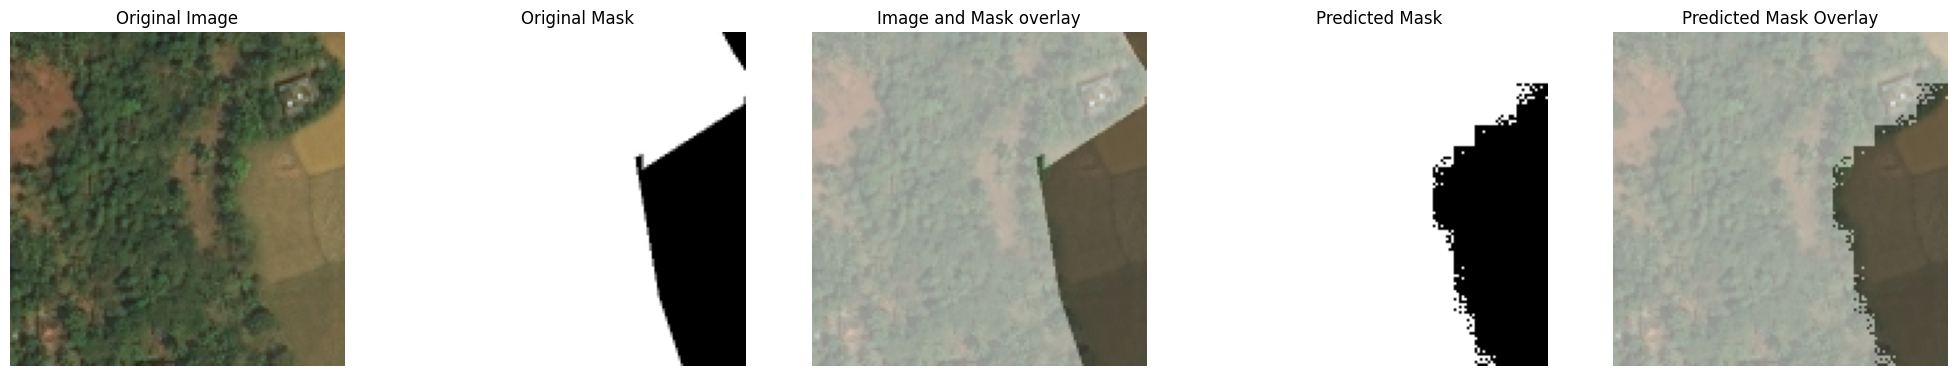

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


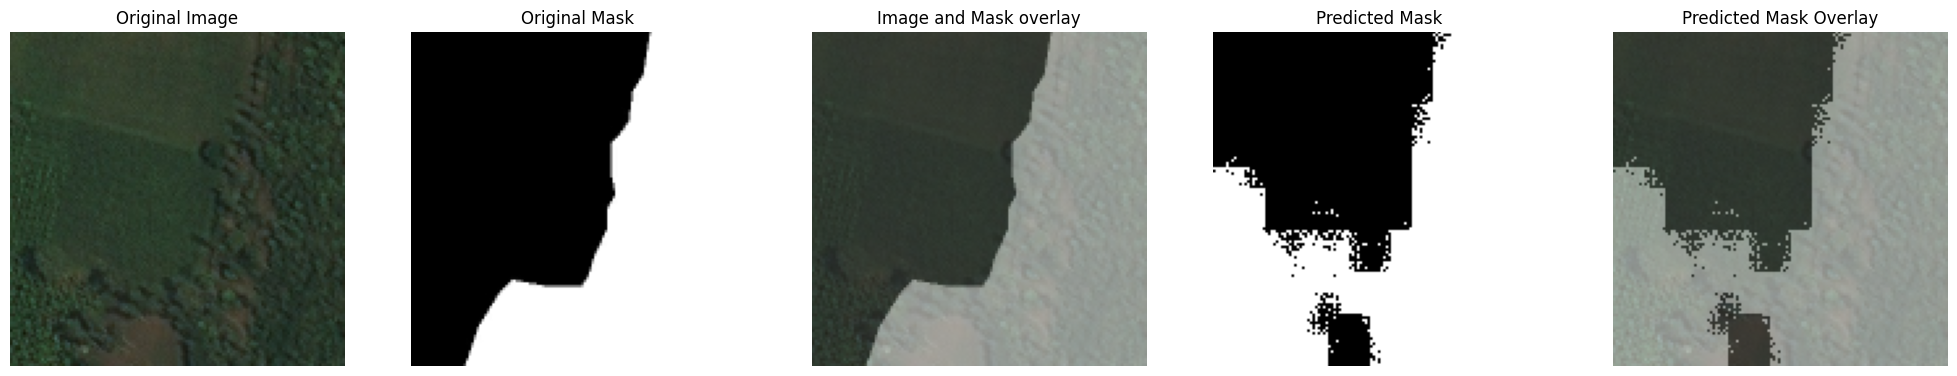

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


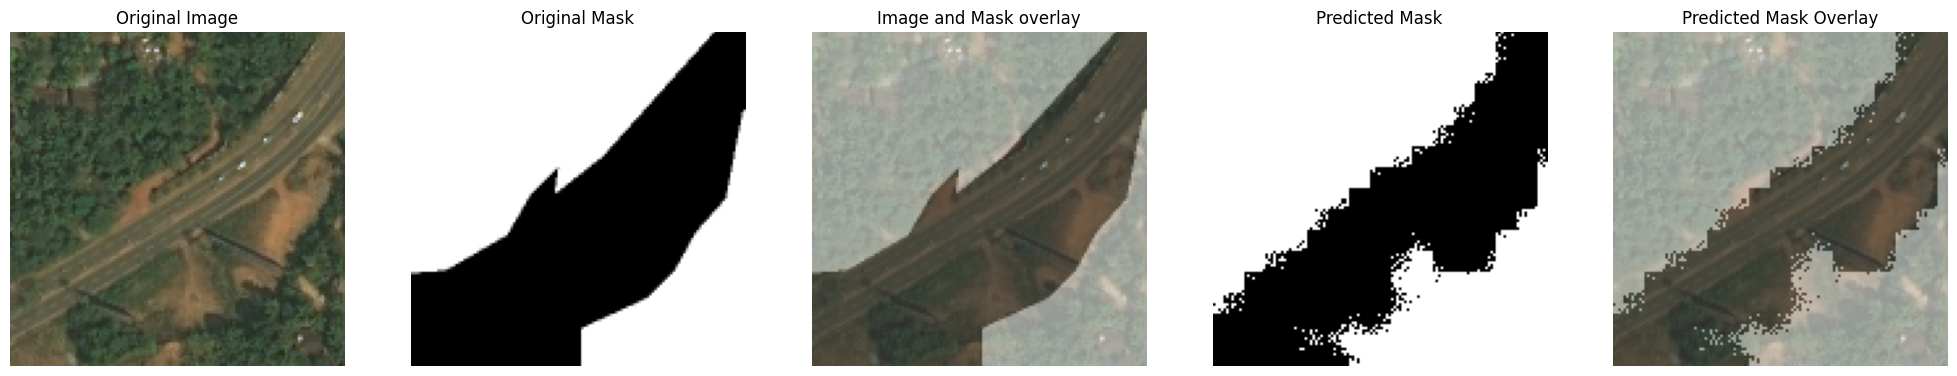

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


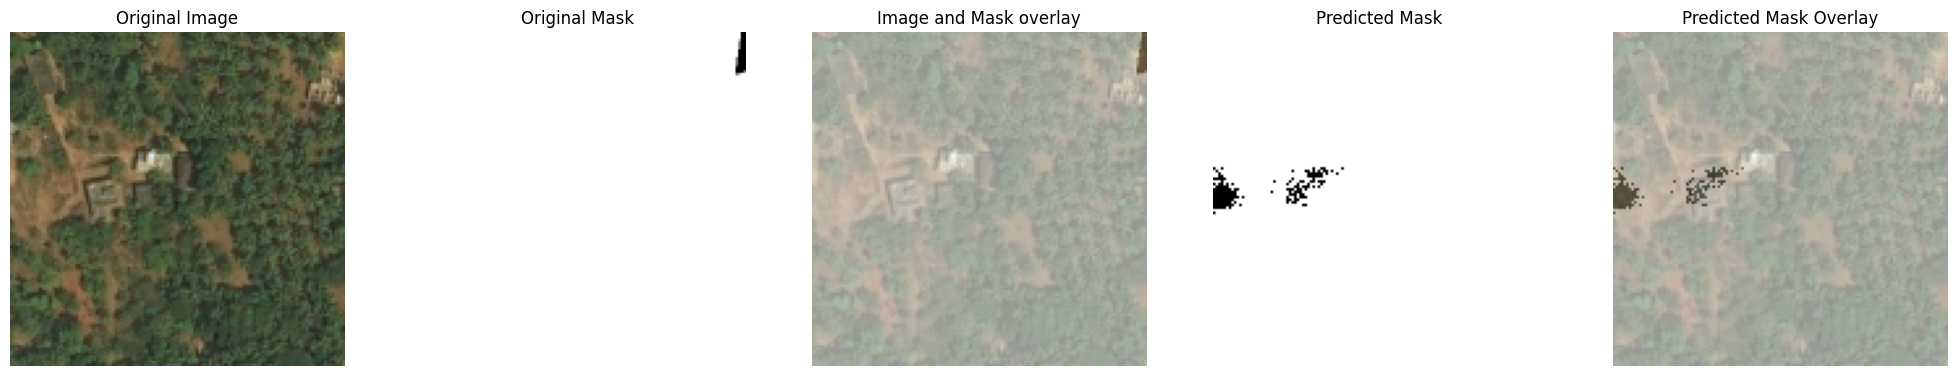

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


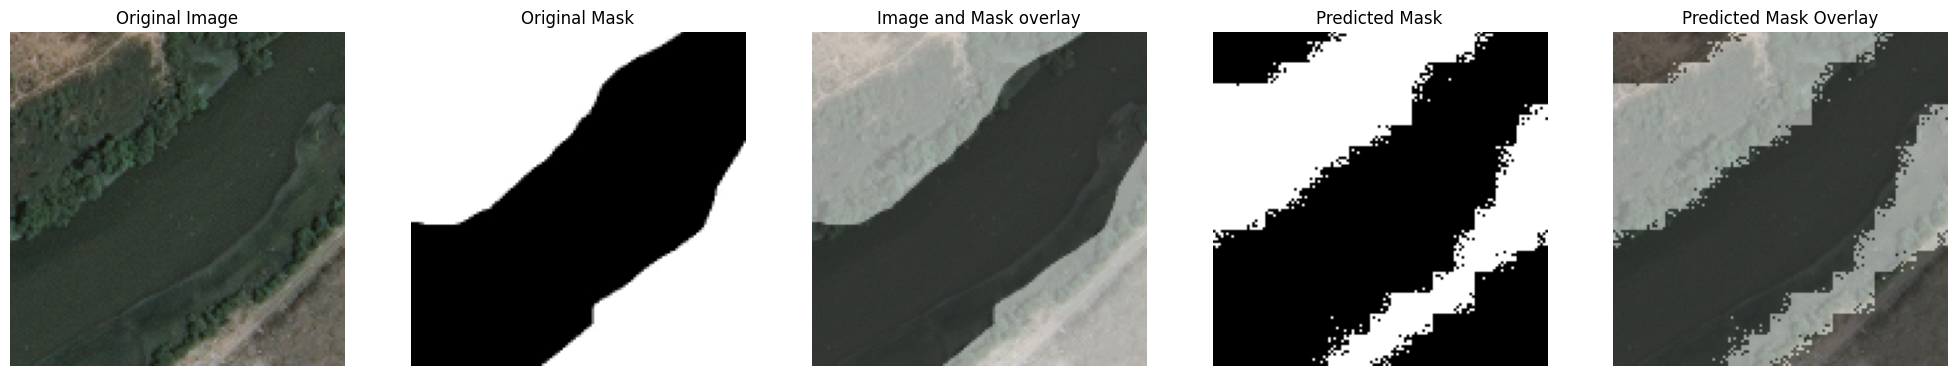

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


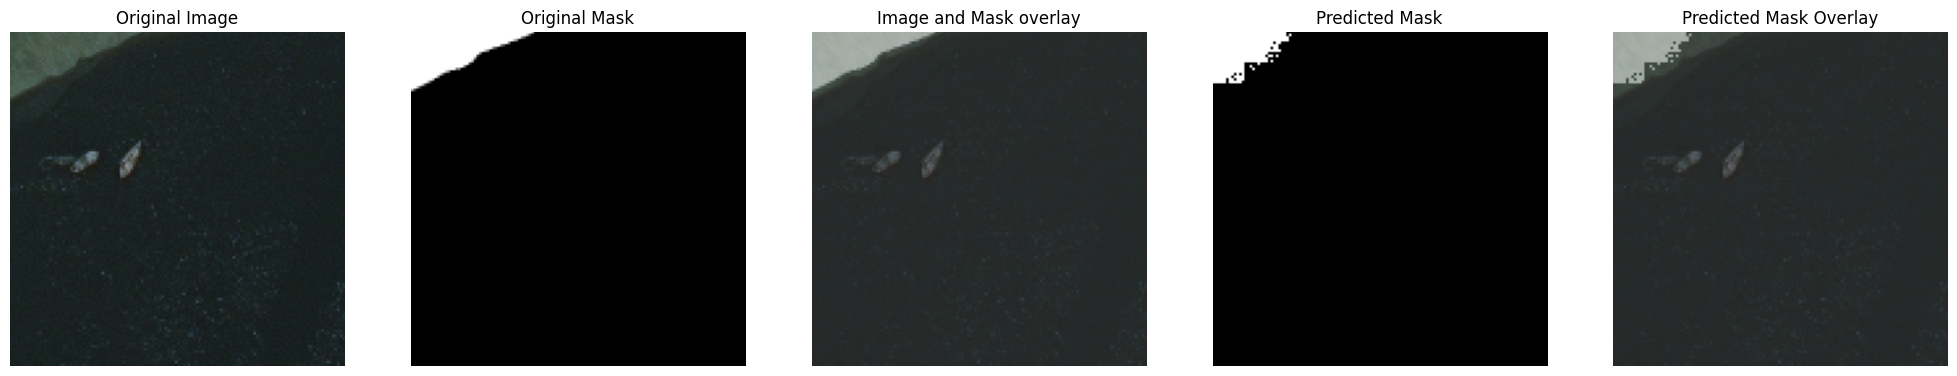

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


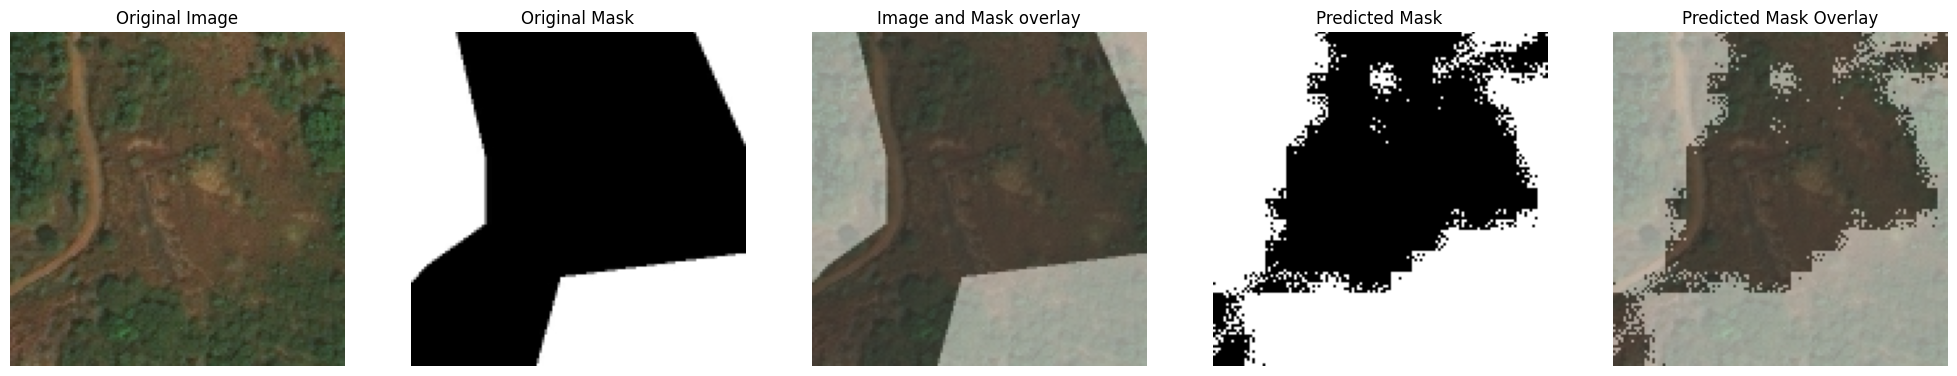

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


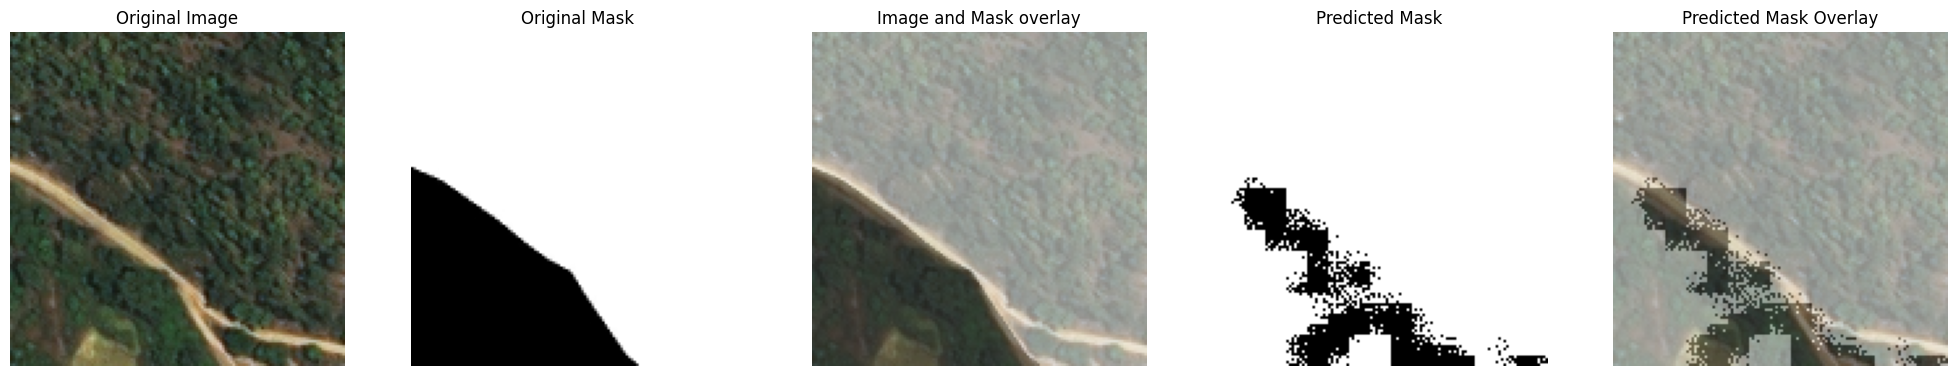

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


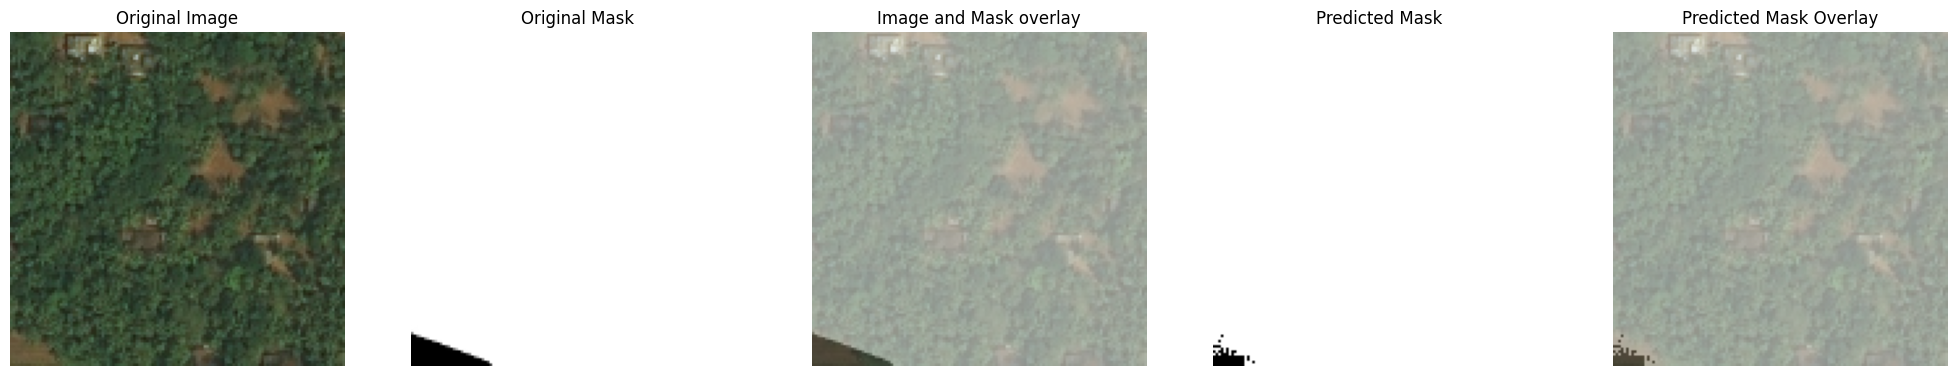

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


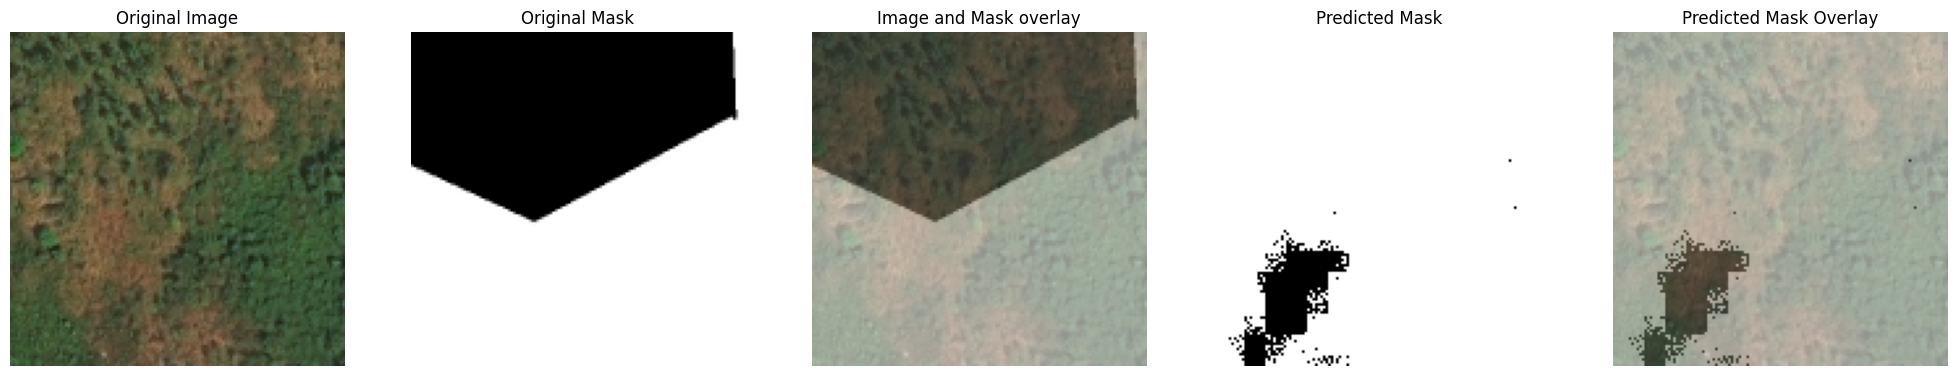

In [152]:
show_images_and_masks(data=train_ds, model=vgg_model)